<a href="https://colab.research.google.com/github/grazder/recommendation_systems/blob/main/RecSys_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
!tar -xf /content/wsdm_data.tar.gz
!mkdir data
!mv -t data members.csv song_extra_info.csv songs.csv train.csv

--2021-11-27 14:20:16--  https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
Resolving voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)... 52.95.169.16
Connecting to voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)|52.95.169.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613394184 (585M) [application/x-gzip]
Saving to: ‘wsdm_data.tar.gz’

wsdm_data.tar.gz    100%[===================>] 584.98M  94.4MB/s    in 6.1s    

2021-11-27 14:20:22 (96.6 MB/s) - ‘wsdm_data.tar.gz’ saved [613394184/613394184]



In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [24]:
import datetime
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from time import time
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

In [3]:
members = pd.read_csv("./data/members.csv")
songs = pd.read_csv("./data/songs.csv")
train = pd.read_csv("./data/train.csv")
songs_extra_info = pd.read_csv("./data/song_extra_info.csv")

In [4]:
train = train.merge(members, on="msno", how="left")
train = train.merge(songs, on="song_id", how="left")

In [5]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language'],
      dtype='object')

In [6]:
train['registration_init_time'] = pd.to_datetime(train["registration_init_time"]).apply(lambda x: x.year).astype("int")
train['expiration_date'] = pd.to_datetime(train["expiration_date"]).apply(lambda x: x.year).astype("int")

train['year_dif'] = train['expiration_date'] - train['registration_init_time']

In [7]:
for col_1, col_2 in [('artist_name', 'composer')]:
    train[col_1 + '_' + col_2] = train[col_1].astype(str) + '_' + train[col_2].astype(str)
    train[col_1 + '_' + col_2] = train[col_1 + '_' + col_2].astype('category').cat.codes

In [8]:
categorical_features = ['artist_name', 'composer', 'lyricist', 'genre_ids', 'language', 'expiration_date', 
                        'registered_via', 'gender', 'bd', 'city', 'source_type', 'language', 
                        'source_screen_name', 'source_system_tab', 'song_id', 'msno']

for col in categorical_features:
    train[col] = train[col].fillna('nan').astype('category').cat.codes

X = train.drop("target", axis=1)
y = train['target']

# Задание 1.

In [ ]:
cat_params = {
                'n_estimators':300,
                'learning_rate': 0.01,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed': 42,
                'metric_period':500,
                'od_wait':500,
                'task_type':'GPU',
                'depth': 8,
                } 

In [77]:
def auc_per_query(users, y_true, y_pred):
    users_unique = np.unique(users)
    scores = []

    for user in tqdm(users_unique):
        try:
            mask = users == user
            user_auc = roc_auc_score(y_true[mask], y_pred[mask])
            scores.append(user_auc)
        except:
            pass

    return np.array(scores).mean()

In [ ]:
oof = np.zeros(len(X))

folds = KFold(n_splits=5, shuffle=True, random_state=47)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    estimator = CatBoostClassifier(**cat_params)        
    estimator.fit(
            X.iloc[trn_idx,:],y[trn_idx],
            eval_set=(X.iloc[test_idx,:], y[test_idx]),
            cat_features=categorical_features,
            use_best_model=True,
            verbose=True)
    
    oof[test_idx] = estimator.predict_proba(X.iloc[test_idx])[:,1]
    feature_importances['fold_{}'.format(fold + 1)] = estimator.get_feature_importance()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('OOF AUC:', auc_per_query(train['msno'], y, oof))
print('-' * 30)

Training on fold 1
0:	learn: 0.7663033	test: 0.7761736	best: 0.7761736 (0)	total: 857ms	remaining: 4m 16s
299:	learn: 0.8120280	test: 0.8263462	best: 0.8263462 (299)	total: 3m 43s	remaining: 0us
bestTest = 0.826346159
bestIteration = 299
Fold 1 finished in 0:06:06.421238
Training on fold 2
0:	learn: 0.7661438	test: 0.7764704	best: 0.7764704 (0)	total: 856ms	remaining: 4m 15s
299:	learn: 0.8116848	test: 0.8265306	best: 0.8265306 (299)	total: 3m 43s	remaining: 0us
bestTest = 0.8265305758
bestIteration = 299
Fold 2 finished in 0:04:56.826049
Training on fold 3
0:	learn: 0.7663526	test: 0.7771254	best: 0.7771254 (0)	total: 846ms	remaining: 4m 13s
299:	learn: 0.8123294	test: 0.8272935	best: 0.8272935 (299)	total: 3m 44s	remaining: 0us
bestTest = 0.8272934854
bestIteration = 299
Fold 3 finished in 0:04:57.221255
Training on fold 4
0:	learn: 0.7665313	test: 0.7767186	best: 0.7767186 (0)	total: 856ms	remaining: 4m 16s
299:	learn: 0.8120313	test: 0.8266802	best: 0.8266802 (299)	total: 3m 44s	re

  0%|          | 0/30755 [00:00<?, ?it/s]

OOF AUC: 0.699385382725422
------------------------------


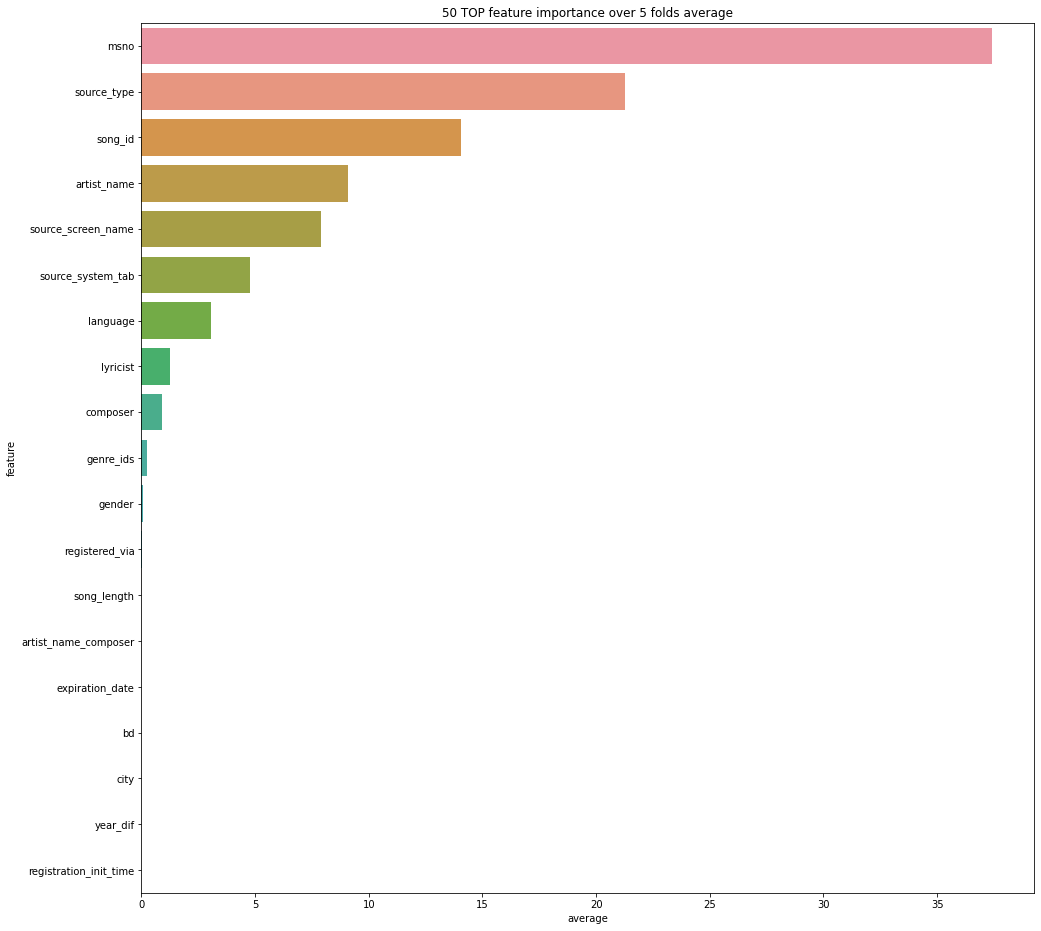

In [ ]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

# Задание 2

Сначала учим эмбеддинги итемов (song_id)

In [39]:
!pip install fasttext

     |████████████████████████████████| 68 kB 5.9 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3125609 sha256=f10a0ffacdbad368e937bf051c5cce3f038f55a276c79e63635b93d3000b3201
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


Готовим датасет и фильтруем items

In [9]:
import csv

fasttext_df = train.copy()

fasttext_vc = fasttext_df['song_id'].value_counts()
popular_items = list(fasttext_vc[fasttext_vc > 50].index)

print(fasttext_df['song_id'].nunique())
fasttext_df = fasttext_df[fasttext_df['song_id'].isin(popular_items)]
print(fasttext_df['song_id'].nunique())

fasttext_df['song_id'] = fasttext_df['song_id'].astype(str)
fasttext_df = fasttext_df.groupby('msno')['song_id'].apply(lambda x: ' '.join(list(x)))
fasttext_df.to_csv('train.txt', index = False, sep = ' ', header = None, 
                   quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")

359966
17593


In [9]:
model = fasttext.train_unsupervised('train.txt', thread=8, verbose=1)
model.save_model("item_embedding_model.bin")

In [10]:
model = fasttext.load_model('item_embedding_model.bin')
words_list = list(model.words)

Посмотрим теперь на симилары

In [18]:
k = 5

groups = train.groupby("genre_ids").count().sort_values("song_id", ascending=False).index.to_numpy()
top_k_groups = groups[1:k + 5]
similars_train = train[train["genre_ids"].isin(top_k_groups)].sample(10000)
similars_train['song_id'] = similars_train['song_id'].astype(str)

print(similars_train.shape)

(10000, 20)


In [22]:
songs_learned = list(set(similars_train['song_id'].unique()).intersection(set(words_list)))

similars_train = similars_train[similars_train['song_id'].isin(songs_learned)]
songs = similars_train['song_id']
genres = similars_train['genre_ids']

print(songs.shape, genres.shape)

(8326,) (8326,)


In [25]:
songs_embeds = []

for song in tqdm(songs):
    songs_embeds.append(model.get_word_vector(song))

songs_embeds = np.array(songs_embeds)

  0%|          | 0/8326 [00:00<?, ?it/s]

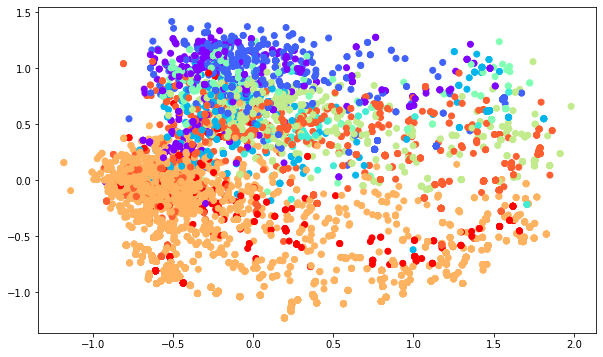

In [30]:
import matplotlib.cm as cm

data = PCA(n_components=2).fit_transform(songs_embeds)

le = LabelEncoder()
labels = le.fit_transform(genres)

n_classes = len(le.classes_)
colors = cm.rainbow(np.linspace(0, 1, n_classes))
colors = [colors[label] for label in labels]

plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], color=colors)

plt.show()

Видим группы цветов, которые находятся близко, но также есть разный разброс

Получим теперь user ембеддинги

In [40]:
full_df = train.copy()
full_df['song_id'] = full_df['song_id'].astype(str)
full_df = full_df.groupby('msno')['song_id'].apply(lambda x: ' '.join(list(x)))

user_embeds = []

for user_i in tqdm(full_df.index):
    user_songs = full_df.iloc[user_i]
    embed = np.mean([model.get_word_vector(x) for x in user_songs], axis=0)

    user_embeds.append(embed)

user_embeds = np.array(user_embeds)
user_embed_dict = {k: v for k, v in zip(full_df.index, user_embeds)}

  0%|          | 0/30755 [00:00<?, ?it/s]

Сделаем предсказания

In [80]:
from sklearn.metrics.pairwise import cosine_similarity

preds = []

for msno, song in tqdm(train[['msno', 'song_id']].values):
    song_embed = model.get_word_vector(str(song))
    user_embed = user_embed_dict[msno]

    preds.append(cosine_similarity([user_embed], [song_embed])[0][0])

preds = np.array(preds)

  0%|          | 0/7377418 [00:00<?, ?it/s]

In [81]:
print('OOF AUC:', auc_per_query(train['msno'], train['target'], preds))

  0%|          | 0/30755 [00:00<?, ?it/s]

OOF AUC: 0.48081598078085064
